### Climate skill at 1&deg;: zonal- and time-means

In [1]:
from typing import List
from collections import namedtuple
import warnings
# beaker downloads trigger this noisy warning
warnings.filterwarnings("ignore", message='install "ipywidgets" for Jupyter support')

import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl

from utils import get_beaker_dataset_variables
from constants import INFERENCE_COMPARISON_1DEG, WANDB_ENTITY, SECONDS_PER_DAY, WANDB_PROJECT

In [2]:
EvalVar = namedtuple("EvalVar", ("name", "long_name", "units", "conversion_factor"))

In [3]:
EVAL_VARS = [
    EvalVar("PRATEsfc", 'surface precipitation', 'mm/day', SECONDS_PER_DAY),
    EvalVar("TMP2m", "2-meter air temperature", "K", None),
#     EvalVar("total_water_path", "total water path", "mm", None),
#     EvalVar("h500", "500hPa height", "m", None),
    EvalVar("UGRD10m", "10m zonal wind speed", "m/s", None)
]

DS_VARS = [
    f'gen_map-{var.name}' for var in EVAL_VARS
] + [
    f'bias_map-{var.name}' for var in EVAL_VARS]

In [4]:
time_mean_datasets = []
for duration_name, duration_runs in INFERENCE_COMPARISON_1DEG.items():
    for source_name, source_runs in duration_runs.items():
        if isinstance(source_runs, dict):
            for ic_name, ic_run in source_runs.items():
                full_key = '/'.join([duration_name, source_name, ic_name])
                print(f"Getting run: {full_key=}")
                ic_dataset = get_beaker_dataset_variables(ic_run, 'time_mean_diagnostics.nc', DS_VARS)
                for var in EVAL_VARS:
                    if var.conversion_factor is not None:
                        ic_dataset[f"gen_map-{var.name}"] = (
                            var.conversion_factor * ic_dataset[f"gen_map-{var.name}"]
                        )
                        ic_dataset[f"bias_map-{var.name}"] = (
                            var.conversion_factor * ic_dataset[f"bias_map-{var.name}"]
                        )
                    ic_dataset[f"target_map-{var.name}"] = (
                        ic_dataset[f"gen_map-{var.name}"] - ic_dataset[f"bias_map-{var.name}"]
                    )
                time_mean_datasets.append(
                    ic_dataset
                    .to_array(dim='variable_name', name=source_name)
                    .expand_dims({'duration': [duration_name], 'IC': [ic_name]})
                )
        else:
            full_key = '/'.join([duration_name, source_name])
            print(f"Getting run: {full_key=}")
            type_dataset = get_beaker_dataset_variables(source_runs, 'time_mean_diagnostics.nc', DS_VARS)
            for var in EVAL_VARS:
                if var.conversion_factor is not None:
                    type_dataset[f"gen_map-{var.name}"] = (
                        var.conversion_factor * type_dataset[f"gen_map-{var.name}"]
                    )
                    type_dataset[f"bias_map-{var.name}"] = (
                        var.conversion_factor * type_dataset[f"bias_map-{var.name}"]
                    )
                type_dataset[f"target_map-{var.name}"] = (
                    type_dataset[f"gen_map-{var.name}"] - type_dataset[f"bias_map-{var.name}"]
                )

            time_mean_datasets.append(
                type_dataset
                .to_array(dim='variable_name', name=source_name)
                .expand_dims({'duration': [duration_name]})
            )
time_mean_ds = xr.merge(time_mean_datasets)

Getting run: full_key='10yr/ERA5-ACEv2'


Getting run: full_key='10yr/SHiELD-AMIP-ACEv2/IC0'


Getting run: full_key='10yr/SHiELD-AMIP-ACEv2/IC1'


Getting run: full_key='10yr/SHiELD-AMIP-ACEv2/IC2'


Getting run: full_key='10yr/SHiELD-AMIP-reference'


Getting run: full_key='10yr/SHiELD-AMIP-vs.-ERA5/IC0'


Getting run: full_key='10yr/SHiELD-AMIP-vs.-ERA5/IC1'


Getting run: full_key='82yr/ERA5-ACEv2'


Getting run: full_key='82yr/SHiELD-AMIP-ACEv2/IC0'


Getting run: full_key='82yr/SHiELD-AMIP-ACEv2/IC1'


Getting run: full_key='82yr/SHiELD-AMIP-ACEv2/IC2'


Getting run: full_key='82yr/SHiELD-AMIP-reference'


Getting run: full_key='82yr/SHiELD-AMIP-vs.-ERA5/IC0'


Getting run: full_key='82yr/SHiELD-AMIP-vs.-ERA5/IC1'


In [5]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rc('font', size=8)

In [6]:
# zonal_mean = time_mean_ds.mean(dim=['lon']).to_array(dim='source').to_dataset(dim='variable_name')
zonal_IC_mean = time_mean_ds.mean(dim=['lon', 'IC']).to_array(dim='source').to_dataset(dim='variable_name')
# zonal_IC_min = time_mean_ds.mean(dim=['lon']).min(['IC']).to_array(dim='source').to_dataset(dim='variable_name')
# zonal_IC_max = time_mean_ds.mean(dim=['lon']).max(['IC']).to_array(dim='source').to_dataset(dim='variable_name')

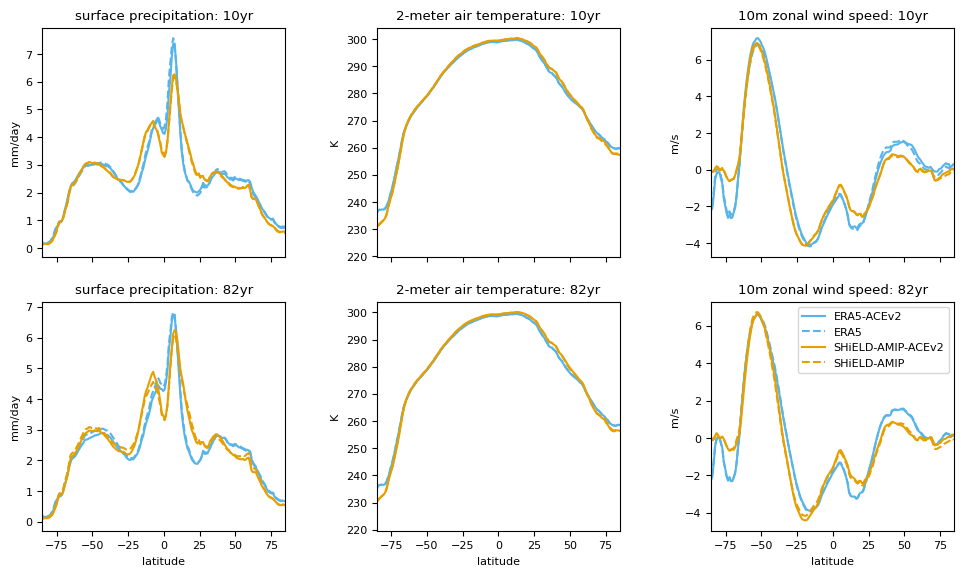

In [8]:
ncols, nrows = len(EVAL_VARS), time_mean_ds.sizes['duration']
fig, axes = plt.subplots(nrows, ncols, sharex='col')
for i, var in enumerate(EVAL_VARS):
    for j, duration in enumerate(time_mean_ds.duration):
        ax = axes[j, i]
        zonal_IC_mean[f'gen_map-{var.name}'].sel(duration=duration, source='ERA5-ACEv2').plot(
            ax=ax, color=colors[0], label='ERA5-ACEv2'
        )
        zonal_IC_mean[f'target_map-{var.name}'].sel(duration=duration, source='ERA5-ACEv2').plot(
            ax=ax, color=colors[0], ls='--', label='ERA5'
        )
#         zonal_IC_min[f'gen_map-{var.name}'].sel(duration=duration, source='SHiELD-AMIP-ACEv2').plot(
#             ax=ax, color=colors[1], label='SHiELD-AMIP-ACEv2'
#         )
#         zonal_IC_max[f'gen_map-{var.name}'].sel(duration=duration, source='SHiELD-AMIP-ACEv2').plot(
#             ax=ax, color=colors[1], label='SHiELD-AMIP-ACEv2'
#         )
        zonal_IC_mean[f'gen_map-{var.name}'].sel(duration=duration, source='SHiELD-AMIP-ACEv2').plot(
            ax=ax, color=colors[1], label='SHiELD-AMIP-ACEv2'
        )
        zonal_IC_mean[f'target_map-{var.name}'].sel(duration=duration, source='SHiELD-AMIP-ACEv2').plot(
            ax=ax, color=colors[1], ls='--', label='SHiELD-AMIP'
        )
#         zonal_IC_mean[f'gen_map-{var.name}'].sel(duration=duration, source='SHiELD-AMIP-reference').plot(
#             ax=ax, color=colors[1], ls='--', label='SHiELD-AMIP IC2'
#         )
        ax.set_title(f"{var.long_name}: {duration.item()}")
        ax.set_xlim([-85, 85])
        ax.set_xlabel(None)
        ax.set_ylabel(f"{var.units}")
for ax in axes[-1, :]:
    ax.set_xlabel("latitude")
ax.legend()
fig.tight_layout()
fig.set_size_inches([10, 6])
fig.savefig('zonal_time_mean.png', bbox_inches='tight', facecolor='w')